In [10]:
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, GlobalAveragePooling2D, Input, Rescaling
from tensorflow.keras.layers import RandomFlip, RandomRotation, RandomZoom, RandomTranslation
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd

# --- 1. Persiapan Data ---
try:
    base_dir = './Dry_Fruit_Image_Dataset'
    if not os.path.exists(base_dir):
         raise FileNotFoundError("Direktori dataset tidak ditemukan. Harap sesuaikan variabel 'base_dir' dengan path yang benar.")
except FileNotFoundError as e:
    print(e)
    exit()

# Parameter
IMG_WIDTH, IMG_HEIGHT = 160, 160 # Diadaptasi ke ukuran standar terdekat MobileNetV2
BATCH_SIZE = 32
NUM_CLASSES = 12

# Membangun daftar file gambar dan labelnya
print("Mencari file gambar...")
image_paths = []
labels = []
for fruit_type_folder in os.listdir(base_dir):
    fruit_type_path = os.path.join(base_dir, fruit_type_folder)
    if os.path.isdir(fruit_type_path):
        for fruit_subtype_folder in os.listdir(fruit_type_path):
            fruit_subtype_path = os.path.join(fruit_type_path, fruit_subtype_folder)
            if os.path.isdir(fruit_subtype_path):
                for image_file in os.listdir(fruit_subtype_path):
                    if image_file.lower().endswith(('.png', '.jpg', '.jpeg')):
                        image_paths.append(os.path.join(fruit_subtype_path, image_file))
                        labels.append(fruit_subtype_folder)

df = pd.DataFrame({'filepath': image_paths, 'class': labels})
print(f"Total gambar ditemukan: {len(df)}")
print(f"Total kelas unik ditemukan: {len(df['class'].unique())}")

# --- Menampilkan Rincian Dataset ---
print("\n--- Rincian Distribusi Dataset ---")
class_counts = df['class'].value_counts().sort_index()
summary_df = pd.DataFrame({'Kelas': class_counts.index, 'Jumlah Gambar': class_counts.values})
print(summary_df.to_string(index=False))
print("------------------------------------\n")

Mencari file gambar...
Total gambar ditemukan: 11520
Total kelas unik ditemukan: 12

--- Rincian Distribusi Dataset ---
         Kelas  Jumlah Gambar
  ALMOND_MAMRA            960
ALMOND_REGULAR            960
 ALMOND_SANORA            960
  CASHEW_JUMBO            960
CASHEW_REGULAR            960
CASHEW_SPECIAL            960
     FIG_JUMBO            960
    FIG_MEDIUM            960
     FIG_SMALL            960
  RAISIN_BLACK            960
 RAISIN_GRADE1            960
RAISIN_PREMIUM            960
------------------------------------



In [11]:

# --- 2. Membuat Data Pipeline dengan tf.data (Cara Modern) ---

# Buat pemetaan dari nama kelas (string) ke indeks integer (0-11)
class_names = sorted(df['class'].unique())
class_to_index = {name: i for i, name in enumerate(class_names)}
df['label_index'] = df['class'].map(class_to_index)

# Acak DataFrame untuk memastikan data terdistribusi secara acak sebelum dibagi
df = df.sample(frac=1, random_state=42).reset_index(drop=True)

# Tentukan ukuran dan bagi dataset
validation_split = 0.2
num_validation_samples = int(validation_split * len(df))
train_df = df.iloc[num_validation_samples:]
val_df = df.iloc[:num_validation_samples]

# Buat tf.data.Dataset dari DataFrame
train_dataset = tf.data.Dataset.from_tensor_slices((train_df['filepath'].values, train_df['label_index'].values))
val_dataset = tf.data.Dataset.from_tensor_slices((val_df['filepath'].values, val_df['label_index'].values))

# Fungsi untuk memuat, memproses, dan melakukan one-hot encoding
def load_and_preprocess_image(filepath, label):
    image = tf.io.read_file(filepath)
    image = tf.io.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, [IMG_WIDTH, IMG_HEIGHT])
    label = tf.one_hot(label, depth=NUM_CLASSES)
    return image, label

# Konfigurasi dataset untuk performa
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.map(load_and_preprocess_image, num_parallel_calls=AUTOTUNE)
train_dataset = train_dataset.cache()
train_dataset = train_dataset.shuffle(buffer_size=len(train_df))
train_dataset = train_dataset.batch(BATCH_SIZE)
train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)

val_dataset = val_dataset.map(load_and_preprocess_image, num_parallel_calls=AUTOTUNE)
val_dataset = val_dataset.cache()
# Gunakan drop_remainder=True untuk memastikan semua batch memiliki ukuran yang sama
val_dataset = val_dataset.batch(BATCH_SIZE, drop_remainder=True)
val_dataset = val_dataset.prefetch(buffer_size=AUTOTUNE)

print("Data pipeline dibuat menggunakan tf.data.Dataset.")
print(f"Sampel Training: {len(train_df)}, Sampel Validasi: {len(val_df)}")

Data pipeline dibuat menggunakan tf.data.Dataset.
Sampel Training: 9216, Sampel Validasi: 2304


In [12]:

# --- 3. Model 1: CNN Sederhana (From Scratch) ---
def create_simple_cnn():
    data_augmentation = Sequential([
        RandomFlip("horizontal"),
        RandomRotation(0.2),
        RandomZoom(0.2),
        RandomTranslation(height_factor=0.2, width_factor=0.2),
    ], name="data_augmentation_simple")

    model = Sequential([
        Input(shape=(IMG_WIDTH, IMG_HEIGHT, 3)),
        Rescaling(1./255),
        data_augmentation,
        Conv2D(32, (3, 3), activation='relu'),
        MaxPooling2D(2, 2),
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D(2, 2),
        Conv2D(128, (3, 3), activation='relu'),
        MaxPooling2D(2, 2),
        Conv2D(256, (3, 3), activation='relu'),
        MaxPooling2D(2, 2),
        Flatten(),
        Dense(512, activation='relu'),
        Dropout(0.5),
        Dense(NUM_CLASSES, activation='softmax')
    ])
    model.compile(optimizer=Adam(learning_rate=0.001),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model

model_1 = create_simple_cnn()
print("--- Arsitektur Model 1: CNN Sederhana ---")
model_1.summary()

--- Arsitektur Model 1: CNN Sederhana ---


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling_4 (Rescaling)         │ (None, 160, 160, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ data_augmentation_simple        │ (None, 160, 160, 3)    │             0 │
│ (Sequential)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 158, 158, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 79, 79, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 77, 77, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 38, 38, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 36, 36, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (None, 18, 18, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 16, 16, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_11 (MaxPooling2D) │ (None, 8, 8, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 16384)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 512)            │     8,389,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 12)             │         6,156 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,783,692 (33.51 MB)

 Trainable params: 8,783,692 (33.51 MB)

 Non-trainable params: 0 (0.00 B)

In [13]:

# --- 4. Model 2: Transfer Learning dengan MobileNetV2 ---
def create_transfer_model():
    data_augmentation = Sequential([
        RandomFlip("horizontal"),
        RandomRotation(0.2),
        RandomZoom(0.2),
        RandomTranslation(height_factor=0.2, width_factor=0.2),
    ], name="data_augmentation_transfer")

    base_model = MobileNetV2(input_shape=(IMG_WIDTH, IMG_HEIGHT, 3),
                             include_top=False,
                             weights='imagenet')
    base_model.trainable = False

    model = Sequential([
        Input(shape=(IMG_WIDTH, IMG_HEIGHT, 3)),
        Rescaling(1./255),
        data_augmentation,
        base_model,
        GlobalAveragePooling2D(),
        Dense(256, activation='relu'),
        Dropout(0.5),
        Dense(NUM_CLASSES, activation='softmax')
    ])
    model.compile(optimizer=Adam(learning_rate=0.001),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model

model_2 = create_transfer_model()
print("\n--- Arsitektur Model 2: Transfer Learning (MobileNetV2) ---")
model_2.summary()


--- Arsitektur Model 2: Transfer Learning (MobileNetV2) ---


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling_5 (Rescaling)         │ (None, 160, 160, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ data_augmentation_transfer      │ (None, 160, 160, 3)    │             0 │
│ (Sequential)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_160            │ (None, 5, 5, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_2      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 256)            │       327,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 12)             │         3,084 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,589,004 (9.88 MB)

 Trainable params: 331,020 (1.26 MB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [14]:

# --- 5. Pelatihan dan Evaluasi ---
EPOCHS = 15

print("\n--- Memulai Pelatihan Model 1: CNN Sederhana ---")
history_1 = model_1.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=EPOCHS,
    verbose=1
)

print("\n--- Memulai Pelatihan Model 2: Transfer Learning ---")
history_2 = model_2.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=EPOCHS,
    verbose=1
)

print("\n--- Evaluasi Model pada Data Validasi ---")
eval_1 = model_1.evaluate(val_dataset)
eval_2 = model_2.evaluate(val_dataset)

print(f"Hasil Model 1 (CNN Sederhana) -> Loss: {eval_1[0]:.4f}, Akurasi: {eval_1[1]*100:.2f}%")
print(f"Hasil Model 2 (Transfer Learning) -> Loss: {eval_2[0]:.4f}, Akurasi: {eval_2[1]*100:.2f}%")


--- Memulai Pelatihan Model 1: CNN Sederhana ---
Epoch 1/15
288/288 ━━━━━━━━━━━━━━━━━━━━ 94s 287ms/step - accuracy: 0.1657 - loss: 2.2672 - val_accuracy: 0.3016 - val_loss: 1.8393
Epoch 2/15
288/288 ━━━━━━━━━━━━━━━━━━━━ 79s 274ms/step - accuracy: 0.2815 - loss: 1.8325 - val_accuracy: 0.3850 - val_loss: 1.4316
Epoch 3/15
288/288 ━━━━━━━━━━━━━━━━━━━━ 79s 275ms/step - accuracy: 0.3781 - loss: 1.5252 - val_accuracy: 0.4614 - val_loss: 1.2657
Epoch 4/15
288/288 ━━━━━━━━━━━━━━━━━━━━ 80s 279ms/step - accuracy: 0.4298 - loss: 1.3707 - val_accuracy: 0.5035 - val_loss: 1.1597
Epoch 5/15
288/288 ━━━━━━━━━━━━━━━━━━━━ 81s 280ms/step - accuracy: 0.4781 - loss: 1.2137 - val_accuracy: 0.5586 - val_loss: 0.9698
Epoch 6/15
288/288 ━━━━━━━━━━━━━━━━━━━━ 81s 283ms/step - accuracy: 0.5143 - loss: 1.1169 - val_accuracy: 0.5842 - val_loss: 0.9122
Epoch 7/15
288/288 ━━━━━━━━━━━━━━━━━━━━ 83s 289ms/step - accuracy: 0.5369 - loss: 1.0404 - val_accuracy: 0.6194 - val_loss: 0.8352
Epoch 8/15
288/288 ━━━━━━━━━━━━━━

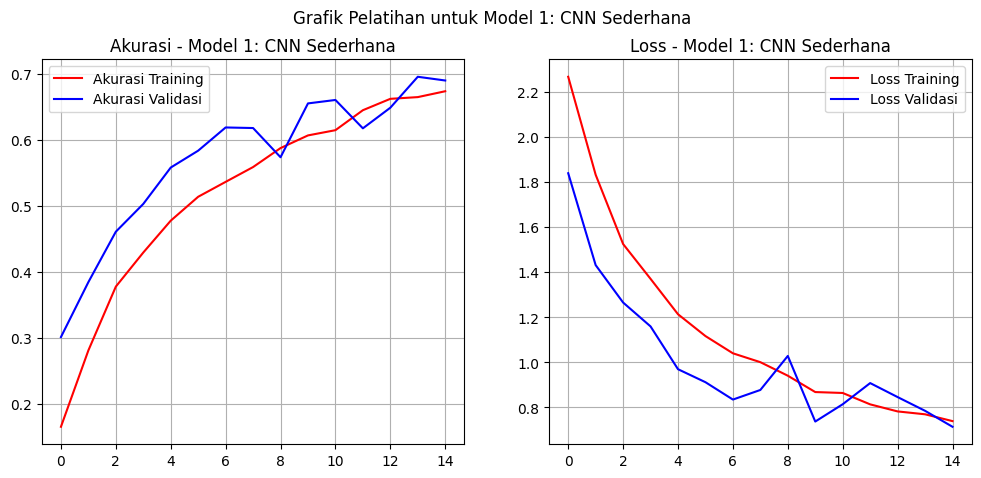

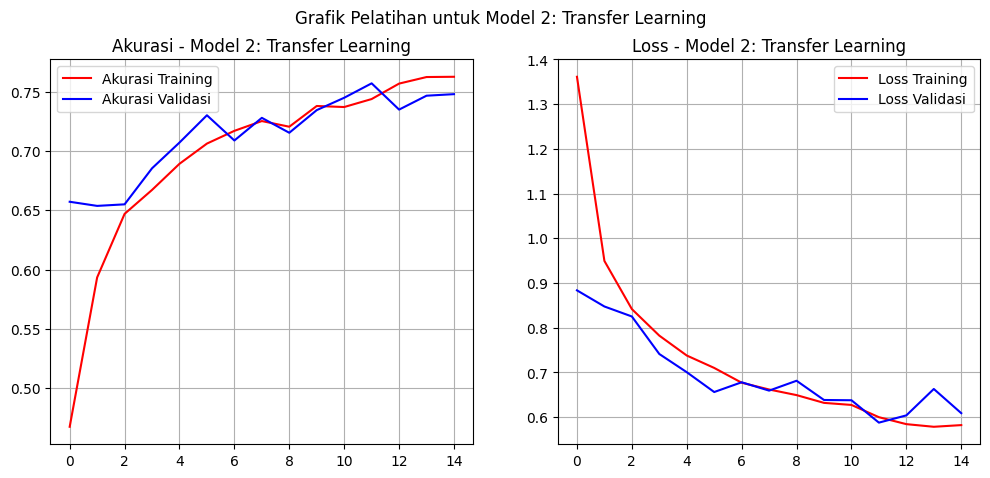

In [15]:

# --- 6. Visualisasi Hasil ---
def plot_history(history, title):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs_range = range(len(acc))

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, 'r', label='Akurasi Training')
    plt.plot(epochs_range, val_acc, 'b', label='Akurasi Validasi')
    plt.title(f'Akurasi - {title}')
    plt.legend()
    plt.grid(True)

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, 'r', label='Loss Training')
    plt.plot(epochs_range, val_loss, 'b', label='Loss Validasi')
    plt.title(f'Loss - {title}')
    plt.legend()
    plt.grid(True)

    plt.suptitle(f"Grafik Pelatihan untuk {title}")
    plt.show()

plot_history(history_1, "Model 1: CNN Sederhana")
plot_history(history_2, "Model 2: Transfer Learning")


--- Visualisasi Hasil Prediksi pada Data Validasi ---
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 276ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 972ms/step

--- Tabel Ringkasan Prediksi untuk Batch Validasi ---
Gambar Index     Label Asli Prediksi Model 1 Prediksi Model 2
    Gambar 0 ALMOND_REGULAR   ALMOND_REGULAR   ALMOND_REGULAR
    Gambar 1   RAISIN_BLACK     RAISIN_BLACK     RAISIN_BLACK
    Gambar 2   CASHEW_JUMBO     CASHEW_JUMBO     CASHEW_JUMBO
    Gambar 3      FIG_SMALL       FIG_MEDIUM        FIG_SMALL
    Gambar 4 RAISIN_PREMIUM   RAISIN_PREMIUM   RAISIN_PREMIUM
    Gambar 5 ALMOND_REGULAR   ALMOND_REGULAR   ALMOND_REGULAR
    Gambar 6   CASHEW_JUMBO   CASHEW_REGULAR   CASHEW_SPECIAL
    Gambar 7 CASHEW_REGULAR   CASHEW_REGULAR     CASHEW_JUMBO
    Gambar 8   RAISIN_BLACK     RAISIN_BLACK     RAISIN_BLACK
    Gambar 9 CASHEW_SPECIAL   CASHEW_SPECIAL   CASHEW_REGULAR
   Gambar 10  ALMOND_SANORA   ALMOND_REGULAR     ALMOND_MAMRA
   Gambar 11 CASHEW_SPECIAL     CASHEW_JUMBO   CASHEW_SPECIAL
   Gam

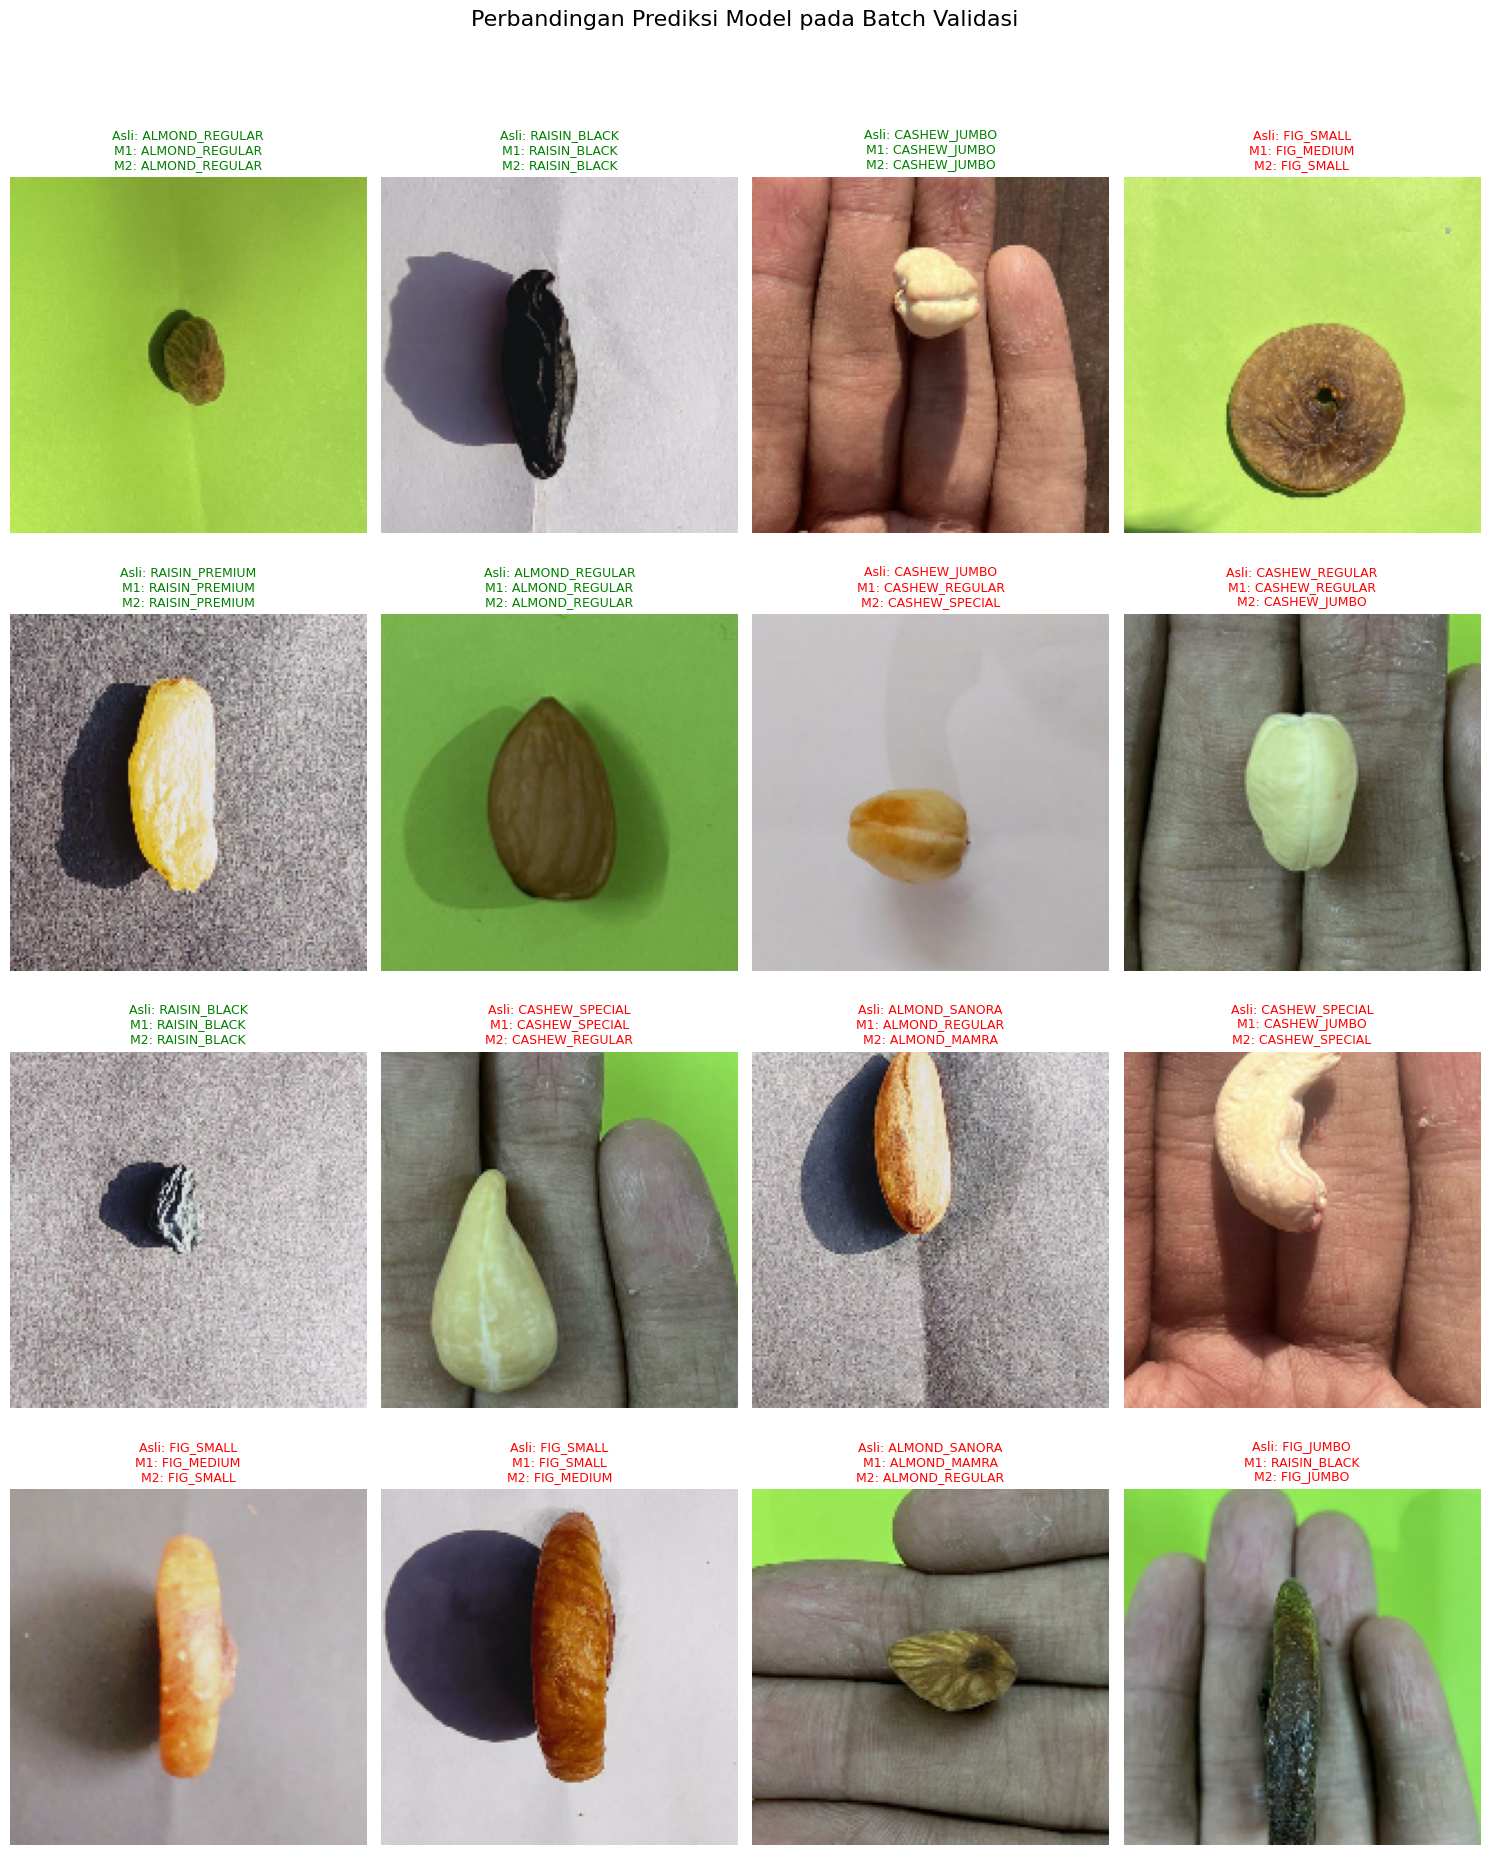

In [16]:

# --- 7. Visualisasi Hasil Prediksi pada Data Validasi ---
print("\n--- Visualisasi Hasil Prediksi pada Data Validasi ---")

# Ambil satu batch dari validation dataset
image_batch, label_batch = next(iter(val_dataset))

# Buat prediksi untuk kedua model
pred_1 = model_1.predict(image_batch)
pred_2 = model_2.predict(image_batch)

# Konversi dari one-hot encoding dan probabilitas ke nama kelas
true_labels = [class_names[np.argmax(label)] for label in label_batch]
pred_labels_1 = [class_names[np.argmax(p)] for p in pred_1]
pred_labels_2 = [class_names[np.argmax(p)] for p in pred_2]

num_images_to_show = min(BATCH_SIZE, 16)

# --- Tabel Ringkasan Prediksi ---
print("\n--- Tabel Ringkasan Prediksi untuk Batch Validasi ---")
prediction_summary_data = {
    "Gambar Index": [f"Gambar {i}" for i in range(num_images_to_show)],
    "Label Asli": true_labels[:num_images_to_show],
    "Prediksi Model 1": pred_labels_1[:num_images_to_show],
    "Prediksi Model 2": pred_labels_2[:num_images_to_show]
}
summary_pred_df = pd.DataFrame(prediction_summary_data)
print(summary_pred_df.to_string(index=False))

# --- Visualisasi Gambar dan Prediksi ---
plt.figure(figsize=(15, 20))
plt.suptitle("Perbandingan Prediksi Model pada Batch Validasi", fontsize=16)

for i in range(num_images_to_show):
    ax = plt.subplot(4, 4, i + 1)
    plt.imshow(image_batch[i].numpy().astype("uint8"))
    plt.axis("off")

    # Tentukan warna judul berdasarkan kebenaran kedua model
    is_m1_correct = pred_labels_1[i] == true_labels[i]
    is_m2_correct = pred_labels_2[i] == true_labels[i]
    title_color = 'green' if is_m1_correct and is_m2_correct else 'red'

    title_str = f"Asli: {true_labels[i]}\n" \
                f"M1: {pred_labels_1[i]}\n" \
                f"M2: {pred_labels_2[i]}"

    plt.title(title_str, color=title_color, fontsize=9)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()
